In [57]:
import numpy as np
import pandas as pd
from numpy import random
from numpy.random import randn
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import kf_book.book_plots as bp

df = pd.read_csv('sensorData.csv')
uwb_x = df.uwb_x
vel_linear_x = df['vel_linear_x'].fillna(0.0)

In [58]:
len(vel_linear_x)

1984

In [3]:
type(uwb_x)

pandas.core.series.Series

In [4]:
uwbXArray= uwb_x.to_numpy()

In [5]:
uwbXArray

array([0. , 0. , 0. , ..., 2.1, 2.1, 2.1])

In [6]:
len(uwbXArray)

1984

In [7]:
len(uwb_x)

1984

In [8]:
# first nonzero value for uwb_x
ini_index = uwb_x.ne(0).idxmax()

In [9]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

In [10]:
import kf_book.kf_internal as kf_internal
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '(={:.3f}, 2={:.3f})'.format(s[0], s[1])
# note: A large variance implies that confidence is very low, 
# so the filter estimates the position to be very close to the measurement
# specific to the robot
process_var = 0.028 ** 2
sensor_var = 0.077 ** 2
# sensor_var = 0.3 ** 2
# initial uwb_x: around 2 when real tag value received and written, otherwise 0.0
x = gaussian(uwb_x[ini_index], sensor_var) # robot's initial position(x-coordinate): first non-zero value of uwb_x

# if changed to 0.1 the kf precision will be lower
dt = 0.01

# measurements are uwb_x
# Kalman filter
print('    PREDICT\t\tMEASURE    UPDATE')
print('  x\t   var\t\tz\t  x\t  var')
# perform kf on measurement
for i, z in enumerate(uwb_x):
    velocity = vel_linear_x[i]
    process_model = gaussian(velocity*dt, process_var)
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)
    
    kf_internal.print_gh(prior, x, z)
print('final estimate X-coordinate:\t{:10.3f} m'.format(x.mean))
print('tag final position:\t\t{:10.3f} m'.format(uwb_x.iloc[-1]))

    PREDICT		MEASURE    UPDATE
  x	   var		z	  x	  var
  1.880    0.007	0.000	  0.882   0.003
  0.882    0.004	0.000	  0.530   0.002
  0.530    0.003	0.000	  0.346   0.002
  0.346    0.003	0.000	  0.234   0.002
  0.234    0.003	0.000	  0.161   0.002
  0.161    0.003	1.880	  0.691   0.002
  0.691    0.003	1.880	  1.054   0.002
  1.054    0.003	1.880	  1.306   0.002
  1.306    0.003	1.880	  1.480   0.002
  1.480    0.003	1.880	  1.602   0.002
  1.602    0.003	1.880	  1.686   0.002
  1.686    0.003	1.880	  1.745   0.002
  1.745    0.003	1.880	  1.786   0.002
  1.786    0.003	1.880	  1.815   0.002
  1.815    0.003	1.870	  1.831   0.002
  1.831    0.003	1.870	  1.843   0.002
  1.843    0.003	1.870	  1.851   0.002
  1.851    0.003	1.870	  1.857   0.002
  1.857    0.003	1.870	  1.861   0.002
  1.861    0.003	1.870	  1.864   0.002
  1.864    0.003	1.870	  1.866   0.002
  1.866    0.003	1.870	  1.867   0.002
  1.867    0.003	1.870	  1.868   0.002
  1.868    0.003	1.890	  1.875   0.002
  1.875  

  2.831    0.003	2.820	  2.827   0.002
  2.832    0.003	2.820	  2.829   0.002
  2.834    0.003	2.820	  2.830   0.002
  2.835    0.003	2.820	  2.830   0.002
  2.835    0.003	2.850	  2.840   0.002
  2.845    0.003	2.850	  2.846   0.002
  2.851    0.003	2.850	  2.851   0.002
  2.856    0.003	2.850	  2.854   0.002
  2.859    0.003	2.850	  2.856   0.002
  2.861    0.003	2.850	  2.858   0.002
  2.863    0.003	2.850	  2.859   0.002
  2.864    0.003	2.850	  2.860   0.002
  2.865    0.003	2.850	  2.860   0.002
  2.865    0.003	2.850	  2.861   0.002
  2.866    0.003	2.900	  2.876   0.002
  2.881    0.003	2.900	  2.887   0.002
  2.892    0.003	2.900	  2.894   0.002
  2.899    0.003	2.900	  2.899   0.002
  2.904    0.003	2.900	  2.903   0.002
  2.908    0.003	2.900	  2.906   0.002
  2.911    0.003	2.900	  2.907   0.002
  2.912    0.003	2.900	  2.909   0.002
  2.914    0.003	2.900	  2.910   0.002
  2.915    0.003	2.930	  2.919   0.002
  2.924    0.003	2.930	  2.926   0.002
  2.931    0.003	2.930	  

  2.889    0.003	2.870	  2.883   0.002
  2.888    0.003	2.830	  2.871   0.002
  2.876    0.003	2.830	  2.862   0.002
  2.867    0.003	2.830	  2.856   0.002
  2.861    0.003	2.830	  2.851   0.002
  2.856    0.003	2.830	  2.848   0.002
  2.853    0.003	2.830	  2.846   0.002
  2.851    0.003	2.830	  2.845   0.002
  2.850    0.003	2.830	  2.844   0.002
  2.849    0.003	2.830	  2.843   0.002
  2.848    0.003	2.830	  2.843   0.002
  2.848    0.003	2.780	  2.827   0.002
  2.832    0.003	2.780	  2.816   0.002
  2.821    0.003	2.780	  2.809   0.002
  2.814    0.003	2.780	  2.804   0.002
  2.809    0.003	2.780	  2.800   0.002
  2.805    0.003	2.780	  2.797   0.002
  2.802    0.003	2.780	  2.796   0.002
  2.801    0.003	2.780	  2.794   0.002
  2.799    0.003	2.780	  2.794   0.002
  2.799    0.003	2.730	  2.778   0.002
  2.783    0.003	2.730	  2.767   0.002
  2.772    0.003	2.730	  2.759   0.002
  2.764    0.003	2.730	  2.754   0.002
  2.759    0.003	2.730	  2.750   0.002
  2.755    0.003	2.730	  

  3.683    0.003	3.680	  3.682   0.002
  3.687    0.003	3.680	  3.685   0.002
  3.690    0.003	3.680	  3.687   0.002
  3.692    0.003	3.680	  3.688   0.002
  3.693    0.003	3.680	  3.689   0.002
  3.694    0.003	3.680	  3.690   0.002
  3.695    0.003	3.680	  3.691   0.002
  3.696    0.003	3.720	  3.703   0.002
  3.708    0.003	3.720	  3.712   0.002
  3.717    0.003	3.720	  3.718   0.002
  3.723    0.003	3.720	  3.722   0.002
  3.727    0.003	3.720	  3.725   0.002
  3.730    0.003	3.720	  3.727   0.002
  3.732    0.003	3.720	  3.728   0.002
  3.733    0.003	3.720	  3.729   0.002
  3.734    0.003	3.720	  3.730   0.002
  3.735    0.003	3.760	  3.743   0.002
  3.748    0.003	3.760	  3.751   0.002
  3.756    0.003	3.760	  3.757   0.002
  3.762    0.003	3.760	  3.762   0.002
  3.767    0.003	3.760	  3.765   0.002
  3.769    0.003	3.760	  3.767   0.002
  3.771    0.003	3.760	  3.768   0.002
  3.773    0.003	3.760	  3.769   0.002
  3.774    0.003	3.760	  3.770   0.002
  3.774    0.003	3.760	  

  2.111    0.003	2.110	  2.111   0.002
  2.111    0.003	2.110	  2.110   0.002
  2.110    0.003	2.110	  2.110   0.002
  2.110    0.003	2.110	  2.110   0.002
  2.110    0.003	2.110	  2.110   0.002
  2.110    0.003	2.110	  2.110   0.002
  2.110    0.003	2.110	  2.110   0.002
  2.110    0.003	2.110	  2.110   0.002
  2.110    0.003	2.110	  2.110   0.002
  2.110    0.003	2.110	  2.110   0.002
  2.110    0.003	2.110	  2.110   0.002
  2.110    0.003	2.110	  2.110   0.002
  2.110    0.003	2.110	  2.110   0.002
  2.110    0.003	2.110	  2.110   0.002
  2.110    0.003	2.110	  2.110   0.002
  2.110    0.003	2.110	  2.110   0.002
  2.110    0.003	2.110	  2.110   0.002
  2.110    0.003	2.110	  2.110   0.002
  2.110    0.003	2.110	  2.110   0.002
  2.110    0.003	2.100	  2.107   0.002
  2.107    0.003	2.100	  2.105   0.002
  2.105    0.003	2.100	  2.103   0.002
  2.103    0.003	2.100	  2.102   0.002
  2.102    0.003	2.100	  2.102   0.002
  2.102    0.003	2.100	  2.101   0.002
  2.101    0.003	2.100	  

In [11]:
from kf_book import book_plots as book_plots
from ipywidgets import interact
from ipywidgets.widgets import IntSlider

# save output in these lists for plotting
xs, predictions = [], []

# process_model = gaussian(velocity, process_var) 

# perform Kalman filter
# x = gaussian(0., 20.**2)
for z in uwb_x:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    # save results
    predictions.append(prior.mean)
    xs.append(x.mean)

def plot_filter(step):
    plt.cla()
    step -= 1
    i = step // 3 + 1
 
    book_plots.plot_predictions(predictions[:i])    
    zs = uwb_x
    if step % 3 == 0:
        book_plots.plot_measurements(zs[:i-1])
        book_plots.plot_filter(xs[:i-1])
    elif step % 3 == 1:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i-1])
    else:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i])
    
    plt.xlim(-50, len(uwb_x) + 75)
    plt.ylim(min(uwb_x) - 0.5, max(uwb_x) + 0.5)
    plt.xlabel("Number of measurements")
    plt.ylabel("X-coordinate (m)")
#     loc=2
    plt.legend(loc='lower right');
#     plt.savefig('kalman_real_velocity.pdf', dpi=300)
# value denotes the initial value of the slider
interact(plot_filter, step=IntSlider(value=len(predictions)*3, min=1, max=len(predictions)*3));

interactive(children=(IntSlider(value=5952, description='step', max=5952, min=1), Output()), _dom_classes=('wi…

Now we try KalmanFilter from filterpy:

In [12]:
def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]]) # location and velocity
    kf.F = np.array([[1., dt],
                     [0.,  1.]])  # state transition matrix
    kf.H = np.array([[1., 0]])    # Measurement function
    kf.R *= R                     # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        kf.Q[:] = Q
    return kf

In [37]:
dt = 0.01
# initial X-coordinate and velocity
x = np.array([uwb_x[ini_index], vel_linear_x[0]]) 
kf = pos_vel_filter(x, P=np.diag([sensor_var, 0.1736111111]), R=sensor_var, Q=process_var, dt=dt)

In [38]:
kf

KalmanFilter object
dim_x = 2
dim_z = 1
dim_u = 0
x = [1.88 0.  ]
P = [[0.005929   0.        ]
     [0.         0.17361111]]
x_prior = [[0. 0.]].T
P_prior = [[1. 0.]
           [0. 1.]]
x_post = [[0. 0.]].T
P_post = [[1. 0.]
          [0. 1.]]
F = [[1.   0.01]
     [0.   1.  ]]
Q = [[1.96e-12 3.92e-10]
     [3.92e-10 7.84e-08]]
R = [[0.005929]]
H = [[1. 0.]]
K = [[0. 0.]].T
y = [[0.]]
S = [[0.]]
SI = [[0.]]
M = [[0.]]
B = None
z = [[None]]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
alpha = 1.0
inv = <function inv at 0x7f4290055290>

In [15]:
# try to get turning point of uwb_x
from scipy.signal import argrelextrema
argrelextrema(uwbXArray, np.less)

(array([], dtype=int64),)

In [16]:
import math

def compute_track(z_var, process_var, count=1, dt=0.01):
    "returns track 1D ndarrays"
    x = uwb_x[ini_index]
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for i in range(count - 1):
        vel = 0.5 if i < 1957 and vel_linear_x[i] else 0.0
        if vel:
            v = vel + (randn() * p_std)
        else:
            v = 0.0
        if i < 736 or 1132 <= i < 1530:
            x += v*dt        
        else:
            x -= v*dt
        xs.append(x)
        zs.append(x + randn() * z_std)        
    xs.append(xs[-1])
    return np.array(xs)

In [17]:
from kf_book.mkf_internal import plot_covariance

def plot_track(ps, actual, zs, cov, std_scale=1,
               plot_P=True, y_lim=None,
               xlabel='time', ylabel='position',
               title='Kalman Filter'):

    count = len(zs)
    zs = np.asarray(zs)

    cov = np.asarray(cov)
    std = std_scale * np.sqrt(cov[:, 0, 0])
    std_top = np.minimum(actual+std, [count + 10])
    std_btm = np.maximum(actual-std, [-50])

    std_top = actual + std
    std_btm = actual - std

    bp.plot_track(actual, c='k')
    bp.plot_measurements(range(1, count + 1), zs)
    bp.plot_filter(range(1, count + 1), ps)

    plt.plot(std_top, linestyle=':', color='k', lw=1, alpha=0.4)
    plt.plot(std_btm, linestyle=':', color='k', lw=1, alpha=0.4)
    plt.fill_between(range(len(std_top)), std_top, std_btm,
                     facecolor='yellow', alpha=0.2, interpolate=True)
    plt.legend(loc=4)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if y_lim is not None:
        plt.ylim(y_lim)
    else:
        plt.ylim((-50, count + 10))

    plt.xlim((-50, count + 50))
    plt.title(title)
    plt.show()
#     plt.savefig('kalman_with_track.pdf', dpi=300)

    if plot_P:
        ax = plt.subplot(121)
        ax.set_title(r"$\sigma^2_x$ (pos variance)")
        plot_covariance(cov, (0, 0))
        ax = plt.subplot(122)
        ax.set_title(r"$\sigma^2_\dot{x}$ (vel variance)")
        plot_covariance(cov, (1, 1))
        plt.show()
        

In [18]:
def run(x0=(0.,0.), P=500, R=0, Q=0, dt=1.0, 
        track=None, zs=None,
        count=0, do_plot=True, **kwargs):
    """
    track is the actual position of the robot, zs are the 
    corresponding measurements. 
    """

    # if no data provided. 
    if zs is None:
        print(f"Measurements are necessary!")
        
    if not track:
        print(f"count = {count}")
        track = compute_track(R, Q, count)

    # create the Kalman filter
    kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)  

    # run the kalman filter and store the results
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)

    xs, cov = np.array(xs), np.array(cov)
    if do_plot:
#       plot_track(xs[:, 0], track, zs, cov, dt=dt, **kwargs)  
        plot_track(xs[:, 0], track, zs, cov, y_lim=(min(uwb_x) - 0.5, max(uwb_x) + 0.5) , xlabel="Number of measurements", ylabel="X-coordinate (m)", **kwargs)
    return xs, cov

In [19]:
x

array([1.88, 0.  ])

count = 1984


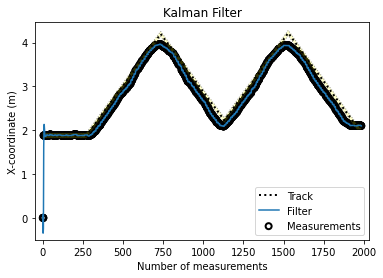

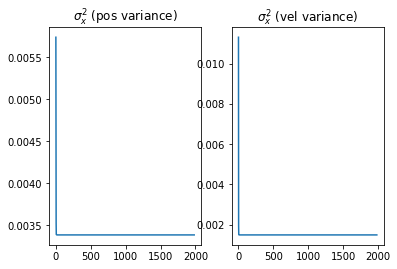

In [31]:
# # initial uncertainty: measurement variance for x-coordinate,
# and x-vel (small value means quite certain)
# maximum speed for the robot is 1.25 m/s, 3 * sigma = 1.25, sigma ** 2 can be calculated
P = np.diag([sensor_var, 0.1736111111])
# set do_plot=False if track data is not available
Ms, Ps = run(x0=x, count=len(uwb_x), R=sensor_var, Q=process_var, P=P, zs=uwb_x, do_plot=True)

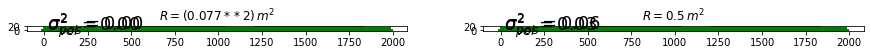

In [35]:
from kf_book.mkf_internal import plot_track_ellipses

def plot_covariances(count, R, Q=process_var, P=sensor_var, title=''):    
    zs = uwb_x
    f = pos_vel_filter(x=(uwb_x[ini_index], 0.), R=R, Q=Q, P=P)

    xs, cov = [], []
    for z in zs:
        f.predict()
        f.update(z)

        xs.append(f.x[0])
        cov.append(f.P)
    plot_track_ellipses(count, zs, xs, cov, title)

plt.figure(figsize=(15,9))
plt.subplot(121)
plot_covariances(R=sensor_var, Q=process_var, count=len(uwb_x), title='$R = (0.077 ** 2)\, m^2$')
plt.subplot(122)
plot_covariances(R=.1, Q=.02, count=len(uwb_x), title='$R = 0.5\, m^2$')

# Batch Processing

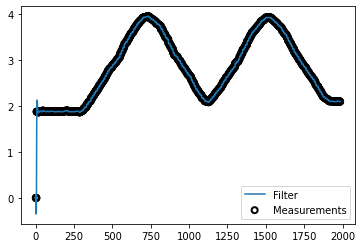

In [36]:
count = len(uwb_x)
zs = uwb_x
# P = np.diag([500., 49.])
f = pos_vel_filter(x=(uwb_x[ini_index], 0.), R=sensor_var, Q=process_var, P=P)
xs, _, _, _ = f.batch_filter(zs)

book_plots.plot_measurements(range(1, count + 1), zs)
book_plots.plot_filter(range(1, count + 1), xs[:, 0])
plt.legend(loc='best');

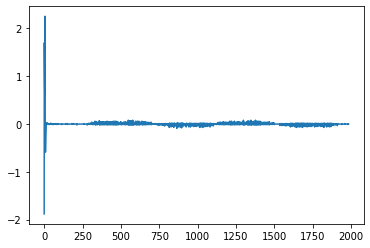

In [43]:
from filterpy.common import Saver
f = pos_vel_filter(x=(uwb_x[ini_index], 0.), R=sensor_var, Q=process_var, P=P)
s = Saver(f)
Xs, Covs, _, _ = f.batch_filter(zs, saver=s)
s.to_array()
plt.plot(s.y)
# plt.savefig('residual.pdf', dpi=300)

From above plot we can see noise centered around 0, which proves that the filter is well designed.

## Smoothing the Results

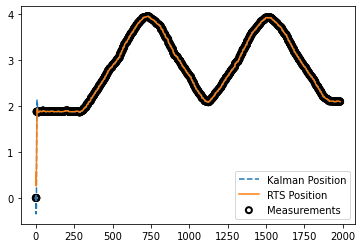

In [46]:
Ms, Ps, _, _ = f.rts_smoother(Xs, Covs)

book_plots.plot_measurements(zs)
plt.plot(Xs[:, 0], ls='--', label='Kalman Position')
plt.plot(Ms[:, 0], label='RTS Position')
plt.legend(loc=4);
# plt.savefig('kalman_with_RTS.pdf', dpi=300)

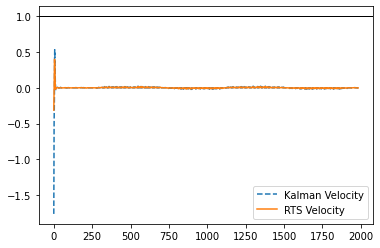

In [48]:
plt.plot(Xs[:, 1], ls='--', label='Kalman Velocity')
plt.plot(Ms[:, 1], label='RTS Velocity')
plt.legend(loc=4)
plt.gca().axhline(1, lw=1, c='k');

In [52]:
dx = np.diff(Xs[:, 0], axis=0)

In [61]:
len(range(1, len(dx) + 1))

1983

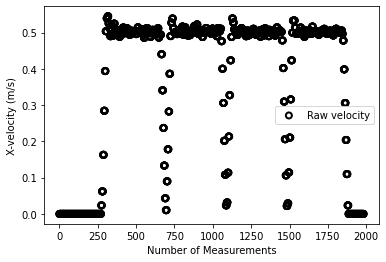

In [68]:
plt.scatter(range(0, len(dx) + 1), vel_linear_x, facecolor='none', 
            edgecolor='k', lw=2, label='Raw velocity')
# plt.plot(Xs[:, 1], ls='--', label='Filter')
# plt.plot(Ms[:, 1], label='RTS')
plt.xlabel("Number of Measurements")
plt.ylabel("X-velocity (m/s)")
plt.legend(loc='best');
# plt.savefig('raw_vel_x.pdf', dpi=300)

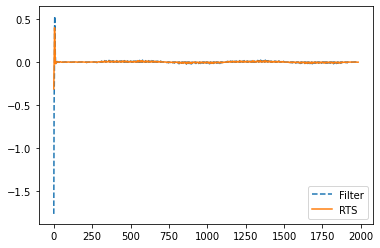